### Total capacity estimation using the xLSalgos function
This notebook implements the different total-capacity estimation methods using the same data set you are already familiar with from last week. Remember that the true capacity of this cell is 10.0 Ah.

In [1]:
% Tests the recursive performance of the xLS algorithms on a particular dataset
% [Qhat,SigmaQ] = xLSalgos(measX,measY,SigmaX,SigmaY,gamma,Qnom,SigmaY0) 
%   - measX = noisy z(2)-z(1)
%   - measY = noisy integral(i(t)/3600 dt)
%   - SigmaX = variance of X
%   - SigmaY = variance of Y
%   - gamma = geometric forgetting factor (gamma = 1 for perfect memory)
%   - Qnom = nominal value of Q: if nonzero, used to initialize recursions
%   - SigmaY0 = variance of uncertainty of nominal capacity
%
%   - Qhat = estimate of capacity at every time step
%     - column 1 = WLS - weighted, recursive
%     - column 2 = WTLS - weighted, but not recursive
%     - column 3 = SCTLS - scaled confidence TLS; recursive and weighted,
%                  but using SigmaX(1) and SigmaY(1) only to determine
%                  factor by which all SigmaX and SigmaY are assumed to be
%                  related
%     - column 4 = AWTLS - recursive and weighted
%   - SigmaQ = variance of Q, computed via Hessian method (columns
%                  correspond to methods in the same way as for Qhat)
function [Qhat,SigmaQ] = xLSalgos(measX,measY,SigmaX,SigmaY,gamma,Qnom,SigmaY0)
  measX = measX(:); measY = measY(:); SigmaX = SigmaX(:); SigmaY = SigmaY(:);
  % Reserve some memory
  Qhat = zeros(length(measX),4); SigmaQ = Qhat; 
  K = sqrt(SigmaX(1)/SigmaY(1));
  
  % Initialize some variables used for the recursive methods
  c1 = 0; c2 =0; c3 = 0; C1 = 0; C2 =0; C3 = 0; C4 = 0; C5 = 0; C6 = 0;
  if Qnom ~= 0,
    c1 = 1/SigmaY0; c2 = Qnom/SigmaY0; c3 = Qnom^2/SigmaY0;
    C1 = 1/(K^2*SigmaY0); C2 = K*Qnom/(K^2*SigmaY0); C3 = K^2*Qnom^2/(K^2*SigmaY0);
    % Init C4...C6 assuming SigmaX0 = K^2*SigmaY0 to match TLS
    C4 = 1/(K^2*SigmaY0); C5 = K*Qnom/(K^2*SigmaY0); C6 = K^2*Qnom^2/(K^2*SigmaY0);    
  end
  
  for iter = 1:length(measX),
    % Compute some variables used for the recursive methods
    c1 = gamma*c1 + measX(iter)^2/SigmaY(iter);
    c2 = gamma*c2 + measX(iter)*measY(iter)/SigmaY(iter);
    c3 = gamma*c3 + measY(iter)^2/SigmaY(iter);

    C1 = gamma*C1 + measX(iter)^2/(K^2*SigmaY(iter));
    C2 = gamma*C2 + K*measX(iter)*measY(iter)/(K^2*SigmaY(iter));
    C3 = gamma*C3 + K^2*measY(iter)^2/(K^2*SigmaY(iter));
    C4 = gamma*C4 + measX(iter)^2/SigmaX(iter);
    C5 = gamma*C5 + K*measX(iter)*measY(iter)/SigmaX(iter);
    C6 = gamma*C6 + K^2*measY(iter)^2/SigmaX(iter);
    
    % Method 1: WLS
    Q = c2./c1; Qhat(iter,1) = Q;
    H = 2*c1;   SigmaQ(iter,1) = 2/H;

    % Method 3: TLS
    Q = (-c1+K^2*c3+sqrt((c1-K^2*c3)^2+4*K^2*c2^2))/(2*K^2*c2);
    Qhat(iter,3) = Q;
    H = ((-4*K^4*c2)*Q^3+(6*K^4*c3-6*c1*K^2)*Q^2+12*c2*K^2*Q+2*(c1-K^2*c3))/(Q^2*K^2+1)^3;
    SigmaQ(iter,3) = 2/H;

    % Method 2: WTLS -- not recursive
    x = measX(1:iter); SX = SigmaX(1:iter); % x, variance of x, already "squared"
    y = measY(1:iter); SY = SigmaY(1:iter); % y, variance of y, already "squared"
    g = gamma.^((iter-1):-1:0)';
    Q = Qhat(iter,3); % initialize with TLS solution
    for k = 1:5,
      J = sum(g.*(2*(Q*x-y).*(Q*y.*SX+x.*SY))./((Q^2*SX+SY).^2));
      H = sum(g.*(2*SY.^2.*x.^2+SX.^2.*(6*Q^2*y.^2-4*Q^3*x.*y) - ...
                     SX.*SY.*(6*Q^2*x.^2-12*Q*x.*y+2*y.^2))./((Q^2*SX+SY).^3));
      Q = Q - J/H;
    end
    Qhat(iter,2)=Q;
    SigmaQ(iter,2)=2/H;    
    if SigmaQ(iter,2)<0 || Q<0, % Sometimes WTLS fails to converge to soln
      Qhat(iter,2) = NaN; SigmaQ(iter,2)=0;
    end    

    % Method 4: AWTLS with pre-scaling
    r = roots([C5 (-C1+2*C4-C6) (3*C2-3*C5) (C1-2*C3+C6) -C2]);
    r = r(r==conj(r)); % discard complex-conjugate roots
    r = r(r>0); % discard negative roots
    Jr = ((1./(r.^2+1).^2).*(r.^4*C4-2*C5*r.^3+(C1+C6)*r.^2-2*C2*r+C3))';
    J = min(Jr);
    Q = r(Jr==J); % keep Q that minimizes cost function
    H = (2/(Q^2+1)^4)*(-2*C5*Q^5+(3*C1-6*C4+3*C6)*Q^4+(-12*C2+16*C5)*Q^3 ...
          +(-8*C1+10*C3+6*C4-8*C6)*Q^2+(12*C2-6*C5)*Q+(C1-2*C3+C6));
    Qhat(iter,4) = Q/K;
    SigmaQ(iter,4) = 2/H/K^2;
  end
end

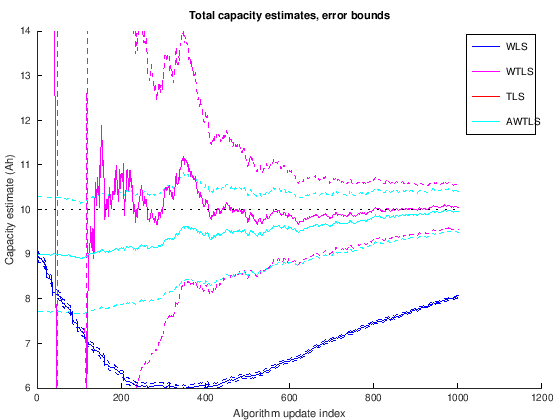

In [2]:
% Set up data for problem; execute the algorithms
load readonly/Lesson425data.mat
Qnom = 9;                        % Initialize nominal capacity
gamma = 1.00;                     % Fading-memory rate constant. Default = 1.00

% Execute the algorithms
[Qhat,SigmaQ] = xLSalgos(x,y,Sigmax,Sigmay,gamma,Qnom,1e-3);

% Plot estimates of capacity
hold on
plot(Qhat(:,1),'b','linewidth',3); % WLS
plot(Qhat(:,2),'m','linewidth',3); % WTLS
plot(Qhat(:,3),'r','linewidth',3); % TLS
plot(Qhat(:,4),'c','linewidth',3); % AWTLS

xlabel('Algorithm update index');
ylabel('Capacity estimate (Ah)');
title('Total capacity estimates, error bounds');
legend('WLS','WTLS','TLS','AWTLS','location','northeast');

% Plot 3-sigma bounds
plot(Qhat(:,1)+3*sqrt(SigmaQ(:,1)),'b--','linewidth',0.5);
plot(Qhat(:,2)+3*sqrt(SigmaQ(:,2)),'m--','linewidth',0.5);
plot(Qhat(:,3)+3*sqrt(SigmaQ(:,3)),'r--','linewidth',0.5);
plot(Qhat(:,4)+3*sqrt(SigmaQ(:,4)),'c--','linewidth',0.5);
plot(Qhat(:,1)-3*sqrt(SigmaQ(:,1)),'b--','linewidth',0.5);
plot(Qhat(:,2)-3*sqrt(SigmaQ(:,2)),'m--','linewidth',0.5);
plot(Qhat(:,3)-3*sqrt(SigmaQ(:,3)),'r--','linewidth',0.5);
plot(Qhat(:,4)-3*sqrt(SigmaQ(:,4)),'c--','linewidth',0.5);

% Plot over top to make sure estimate is on top of bounds
plot(Qhat(:,1),'b','linewidth',3); % WLS
plot(Qhat(:,2),'m','linewidth',3); % WTLS
plot(Qhat(:,3),'r','linewidth',3); % TLS
plot(Qhat(:,4),'c','linewidth',3); % AWTLS

% Plot true capacity
plot([1 length(x)],[10 10],'k:','linewidth',1);  ylim([6 14]);

In [3]:
3*sqrt(SigmaQ(end,1))
3*sqrt(SigmaQ(end,2))
3*sqrt(SigmaQ(end,3))
3*sqrt(SigmaQ(end,4))

ans =  0.027460
ans =  0.48712
ans =  0.45695
ans =  0.45695
